In [77]:
import re
import nltk
import string
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from numpy import sqrt
from numpy import argmax
from sklearn import metrics
from zipfile import ZipFile 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [78]:
path = r"/content/drive/My Drive/DataSet/Disaster_Tweets_Train.csv"
df = pd.read_csv(path, encoding='latin-1',usecols=[3,4])

In [79]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [80]:
pd.value_counts(df.target)

0    4342
1    3271
Name: target, dtype: int64

<BarContainer object of 2 artists>

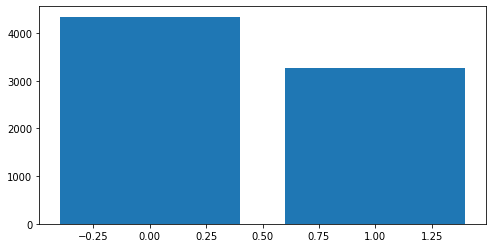

In [81]:
val_count = df.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)


In [82]:
df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [83]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
punctuation=[]
for i in string.punctuation:
    punctuation.append(i)

def text_processing(text):
    text=text.lower()
    re_exp=r"http.\S+|[^a-zA-z0-9]|#\S*|@\S*|\[.+\]"
    text=re.sub(re_exp," ",text)
    sentence=[]
    for word in text.split():
        if word not in stop_words:
            if word not in punctuation:
                sentence.append(stemmer.stem(word))
    return " ".join(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
df.text=df.text.apply(lambda x: text_preprocessing(x) )

In [85]:
df

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13 000 peopl receiv wildfir evacu order califo...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...
7608,two giant crane hold bridg collaps nearbi home,1
7609,control wild fire california even northern par...,1
7610,m1 94 01 04 utc 5km volcano hawaii,1
7611,polic investig e bike collid car littl portug ...,1


In [86]:
X_train, X_test, y_train, y_test = train_test_split(df["text"],df["target"], test_size=0.10, random_state=48)

In [87]:
training_sentences = []
testing_sentences = []

print('prepearing train and test...')
# Train
for s in X_train:
    training_sentences.append(s)
#Test
for s in X_test:
    testing_sentences.append(s)


prepearing train and test...


In [88]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [89]:
vocab_len=10000
max_len=150
truncating_type="post"
emb_dimension=200
oov_string= "<OOV>"
tokenizer = Tokenizer(num_words = vocab_len, oov_token= oov_string)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_len, truncating=truncating_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len)

In [90]:
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len,emb_dimension),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(254,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         135680    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 254)               260350    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [91]:
history = model.fit(padded,
                    y_train,
                    epochs=2,
                    batch_size=100,
                    validation_data=(testing_padded,y_test)
                    )

Epoch 1/2
69/69 [==============================] - 5s 68ms/step - loss: 0.5378 - accuracy: 0.7234 - val_loss: 0.4280 - val_accuracy: 0.8123
Epoch 2/2
69/69 [==============================] - 3s 48ms/step - loss: 0.3057 - accuracy: 0.8807 - val_loss: 0.4659 - val_accuracy: 0.8045


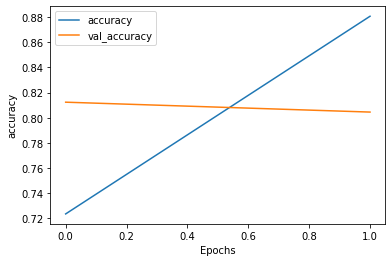

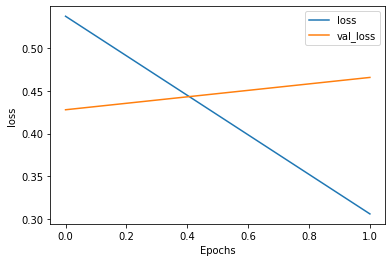

In [92]:
def plotgraph (history,string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_"+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,"val_"+string])
  plt.show()

plotgraph (history,"accuracy")
plotgraph (history,"loss")

In [93]:
preds = model.predict(testing_padded)
print(classification_report(y_test, preds.round()))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       437
           1       0.83      0.68      0.75       325

    accuracy                           0.80       762
   macro avg       0.81      0.79      0.79       762
weighted avg       0.81      0.80      0.80       762



Text(33.0, 0.5, 'True')

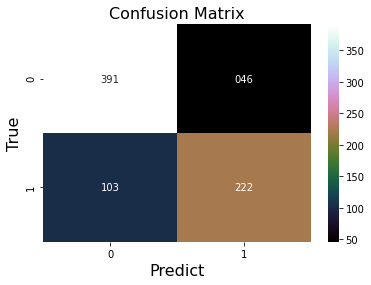

In [94]:
cf_matrix = confusion_matrix(y_test, preds.round())
f,ax=plt.subplots()
sns.heatmap(cf_matrix,annot=True,cmap='cubehelix',fmt="03") 
ax.set_title('Confusion Matrix',fontsize=16)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16) 

In [95]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=None)
thresholds

array([1.9998902 , 0.9998902 , 0.9996799 , 0.99966025, 0.9989151 ,
       0.99887913, 0.9986469 , 0.9985794 , 0.99738914, 0.99736005,
       0.99717987, 0.99702615, 0.99629647, 0.99623907, 0.9935499 ,
       0.99271786, 0.99210703, 0.9917317 , 0.9900221 , 0.98971456,
       0.98427653, 0.98424476, 0.9834404 , 0.9827717 , 0.9751635 ,
       0.9742969 , 0.96042573, 0.9602926 , 0.95191085, 0.95106626,
       0.9335476 , 0.93312114, 0.924351  , 0.9227797 , 0.91916174,
       0.9168955 , 0.88823813, 0.8844691 , 0.8625339 , 0.8617845 ,
       0.8604055 , 0.86018056, 0.8589116 , 0.85697556, 0.8567519 ,
       0.85594434, 0.8428407 , 0.84270525, 0.81616014, 0.8150235 ,
       0.8122632 , 0.8073336 , 0.80367225, 0.80352765, 0.80165344,
       0.7988808 , 0.7969462 , 0.7783579 , 0.7777088 , 0.7722347 ,
       0.76558703, 0.75490296, 0.7506781 , 0.74178857, 0.7391951 ,
       0.7222927 , 0.71472627, 0.68599325, 0.6845994 , 0.6764311 ,
       0.67133427, 0.6565104 , 0.63824874, 0.6346802 , 0.61566

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.358036, G-Mean=0.790


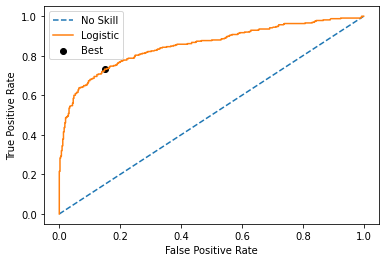

In [97]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [98]:
df

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13 000 peopl receiv wildfir evacu order califo...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...
7608,two giant crane hold bridg collaps nearbi home,1
7609,control wild fire california even northern par...,1
7610,m1 94 01 04 utc 5km volcano hawaii,1
7611,polic investig e bike collid car littl portug ...,1


In [99]:
X_train, X_test, y_train, y_test = train_test_split(df["text"],df["target"], test_size=0.2,random_state=2316)

In [100]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500)
X_train=vectoriser.fit_transform(X_train)
X_test=vectoriser.fit_transform(X_test)

In [101]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    f,ax=plt.subplots()
    sns.heatmap(cf_matrix,annot=True,cmap='cubehelix',fmt="05") 
    ax.set_title('Confusion Matrix',fontsize=16)
    ax.set_xlabel('Predict',fontsize=16)
    ax.set_ylabel('True',fontsize=16) 


              precision    recall  f1-score   support

           0       0.64      0.66      0.65       883
           1       0.51      0.49      0.50       640

    accuracy                           0.59      1523
   macro avg       0.58      0.58      0.58      1523
weighted avg       0.59      0.59      0.59      1523



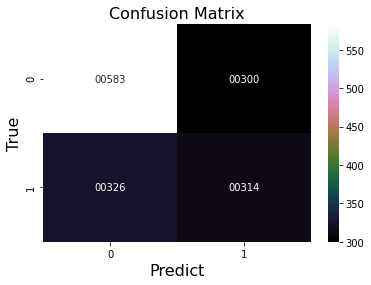

In [102]:
BNBmodel = BernoulliNB(alpha = 2).fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.64      0.67      0.65       883
           1       0.51      0.48      0.50       640

    accuracy                           0.59      1523
   macro avg       0.58      0.58      0.58      1523
weighted avg       0.59      0.59      0.59      1523



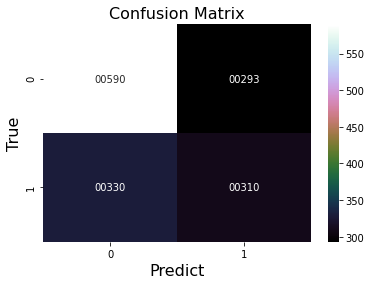

In [103]:
SVCmodel = LinearSVC().fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       883
           1       0.51      0.46      0.49       640

    accuracy                           0.59      1523
   macro avg       0.57      0.57      0.57      1523
weighted avg       0.58      0.59      0.59      1523



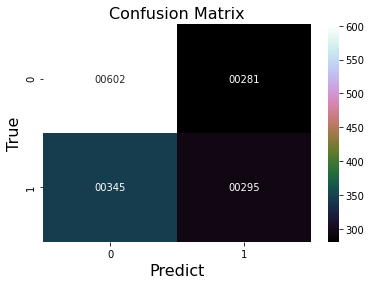

In [104]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1).fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       883
           1       0.48      0.45      0.46       640

    accuracy                           0.56      1523
   macro avg       0.55      0.55      0.55      1523
weighted avg       0.56      0.56      0.56      1523



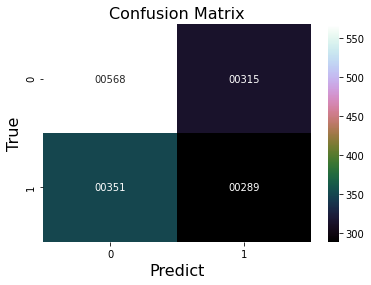

In [105]:
Multinomial_model = MultinomialNB().fit(X_train,y_train)
model_Evaluate(Multinomial_model)